<a href="https://colab.research.google.com/github/connorrupnow/CHEM507_machinelearning/blob/main/Perovskite_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO DO:
- Try discarding corresponding number of training data points for smaller class
- Proper label for SVM is 1 and -1 . sklearn relabels it for you. But for tensorflow make sure to label it properly. Changing it in sklearn doesn't change anything.
- Try using a sum or product of kernels
- What is a reason for the results to be worse?
  - **ANS**: Overfitting is in the complexity of the kernels

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2
from sklearn import svm
from seaborn import pairplot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_data_file = '/content/drive/MyDrive/CHEM507B/connors_applications/perovskite_data.csv'
df = pd.read_csv(csv_data_file,skiprows=1).dropna(axis='columns')
df.sample(5)

,Tf,A_i_r,A_M_B_electronegativity,A_e_affinity,A_IP_0,B1_i_r,B1_M_B_electronegativity,B1_e_affinity,B1_IP_2,B2_i_r,B2_M_B_electronegativity,B2_e_affinity,B2_IP_2,X_i_r,X_e_negativity,X_e_affinity,output_label
1572,0.855512,1.72,0.80,0.485920,4.17713,1.28,1.07,1.302000,7.57620,0.800,1.63,0.300,28.030,2.20,2.76,3.059037,0
281,1.036863,1.72,0.80,0.485920,4.17713,0.92,0.90,0.618049,5.39172,0.580,2.27,0.814,28.351,1.33,3.78,3.401189,1
785,0.884183,1.88,0.77,0.471626,3.89390,1.37,1.19,2.308630,9.22550,0.912,1.15,0.518,22.800,1.81,2.98,3.612724,1
978,0.778466,1.64,0.80,0.501470,4.34066,1.72,0.80,0.485920,4.17713,0.900,1.41,0.307,20.520,1.96,2.83,3.363588,1
410,0.927602,1.72,0.80,0.485920,4.17713,1.39,0.89,0.547926,5.13908,0.600,1.76,1.156,35.190,1.33,3.78,3.401189,0


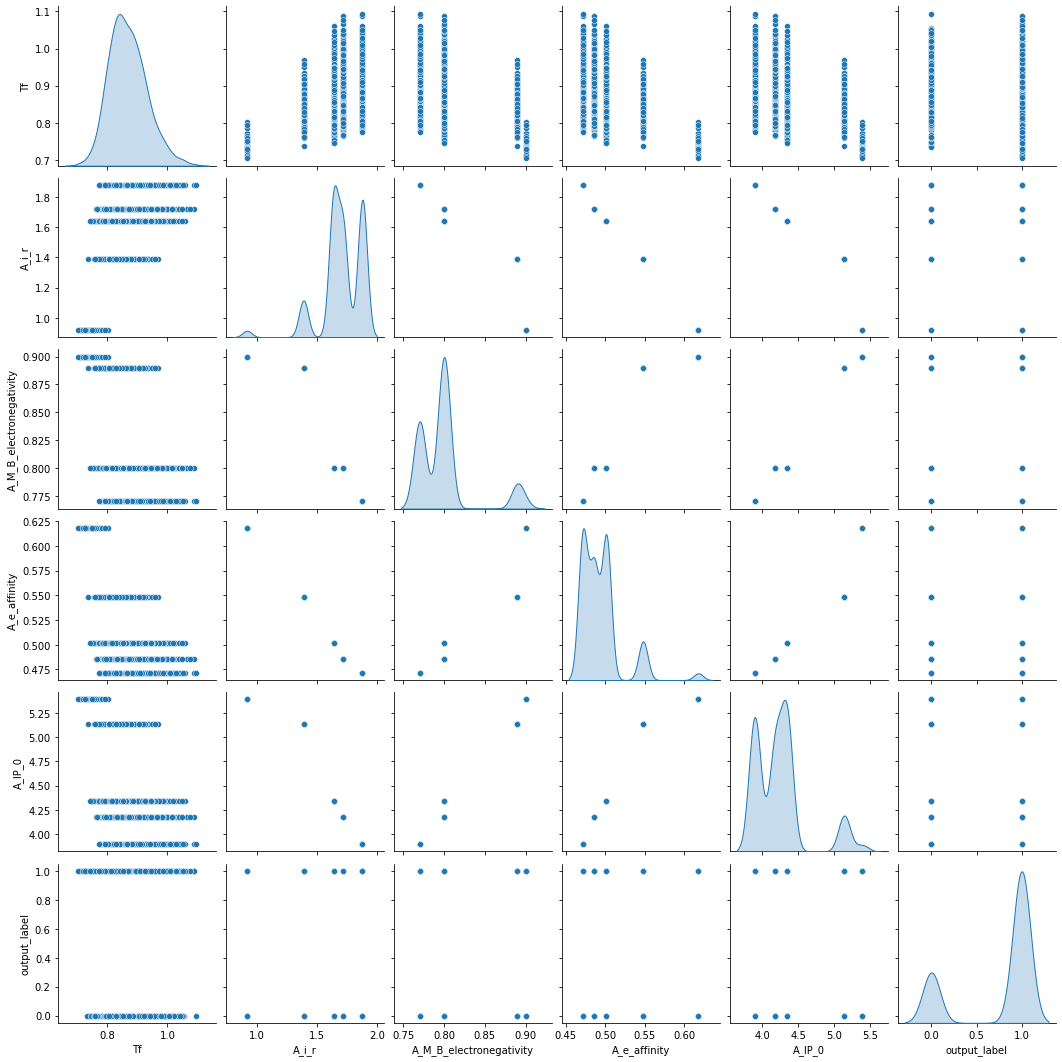

In [ ]:
pairplot(df[['Tf','A_i_r','A_M_B_electronegativity','A_e_affinity','A_IP_0','output_label']],diag_kind='kde')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
normalized_inputs = scaler.fit_transform(df.drop(['output_label'], axis=1))
normalized_data = np.append(normalized_inputs, np.array(df['output_label']).reshape(-1,1), axis=1)

In [ ]:
#Split the data
# metal (1) or non-metal (0)
random_seed = 1

from sklearn.model_selection import train_test_split
training, validation = train_test_split(normalized_data, test_size=0.2, random_state=random_seed)

# y_train = training['output_label']
# X_train = training.drop(['output_label'], axis=1)
y_train = training[:,-1]
X_train = training[:,:-1]

# y_validation = validation['output_label']
# X_validation = validation.drop(['output_label'], axis=1)
y_validation = validation[:,-1]
X_validation = validation[:,:-1]

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(1313, 16) (1313,)
(329, 16) (329,)


## sklearn SVM

NameError: ignored

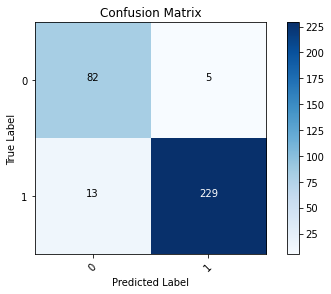

In [ ]:
c=50
rbf_model = svm.SVC(C=c,kernel='rbf') 
rbf_model.fit(X_train, y_train)
rbf_predictions = rbf_model.predict(X_validation)

def create_cm(y_actual,y_predicted,norm=False):
  data_for_cm_calc = pd.DataFrame(list(zip(y_validation,y_predicted)),columns=['actual_class','pred_class'])
  cm = pd.crosstab(data_for_cm_calc['actual_class'], data_for_cm_calc['pred_class'], rownames=['Actual'], colnames=['Predicted'])
  if norm == True:
    cm = cm/cm.sum(axis=1)
  return cm

rbf_cm = create_cm(y_validation,rbf_predictions)

#Confusion Matrix
def plot_confusion_matrix(cm, names=['0','1'], title="Confusion Matrix", cmap=plt.cm.Blues):
    #cm is a pandas dataframe
    plt.imshow(cm,interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    max_val = max(cm.max())
    for row in range(len(cm)):
        for col in range(len(cm[0])):
            # if the colour is light make the test black
            if cm[row][col]/max_val > 0.6:
                plt.annotate(cm[row][col], # this is the text
                             (row,col), # this is the point to label
                             ha='center',
                             color=str(1)) # horizontal alignment can be left, right or center
            # if the colour is dark make the test white
            else:
                plt.annotate(cm[row][col], # this is the text
                             (row,col), # this is the point to label
                             ha='center',
                             color=str(0)) # horizontal alignment can be left, right or center

plot_confusion_matrix(rbf_cm)
test_accuracy(rbf_cm)

In [ ]:
#let's try other kernels with the same data
linear_model = svm.SVC(C=c,kernel='linear') # compare different kernels
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_validation)
linear_cm = create_cm(y_validation,linear_predictions)

sigmoid_model = svm.SVC(C=c,kernel='sigmoid') 
sigmoid_model.fit(X_train, y_train)
sigmoid_predictions = sigmoid_model.predict(X_validation)
sigmoid_cm = create_cm(y_validation,sigmoid_predictions)

d=5
polynomial_model = svm.SVC(C=c,kernel='poly', degree=d) 
polynomial_model.fit(X_train, y_train)
polynomial_predictions = polynomial_model.predict(X_validation)
polynomial_cm = create_cm(y_validation,polynomial_predictions)

def test_accuracy(cm):
  acc = (cm[0][0]+cm[1][1])/cm.sum().sum()
  return acc

print('rbf accuracy', test_accuracy(rbf_cm))
print('linear accuracy', test_accuracy(linear_cm))
print('sigmoid accuracy', test_accuracy(sigmoid_cm))
print('polynomial of degree', d, 'accuracy', test_accuracy(polynomial_cm))